# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

## Reading Dataset

In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

#  Data Understanding

In [3]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
heart_failure_count = df['HeartDisease'].value_counts()
heart_failure_count

HeartDisease
1    508
0    410
Name: count, dtype: int64

# Data Preprocessing

In [8]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [9]:
df['Sex'].value_counts()

Sex
M    725
F    193
Name: count, dtype: int64

In [10]:
df.Sex = df.Sex.map({'M':0,'F':1})

In [11]:
df['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [12]:
df.ChestPainType = df.ChestPainType.map({'ATA':0,'NAP':1,'ASY':2,'TA':3})

In [13]:
df['RestingECG'].value_counts()

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [14]:
df.RestingECG = df.RestingECG.map({'Normal':0,'ST':1,'LVH':2})

In [15]:
df['ExerciseAngina'].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [16]:
df.ExerciseAngina = df.ExerciseAngina.map({'N':0,'Y':1})

In [17]:
df.ST_Slope = df.ST_Slope.map({'Up':0,'Flat':1,'Down':2})

# Exploratory Data Analysis

Text(0.5, 1.0, 'Heart Disease Distribution Based on Chest Pain Type')

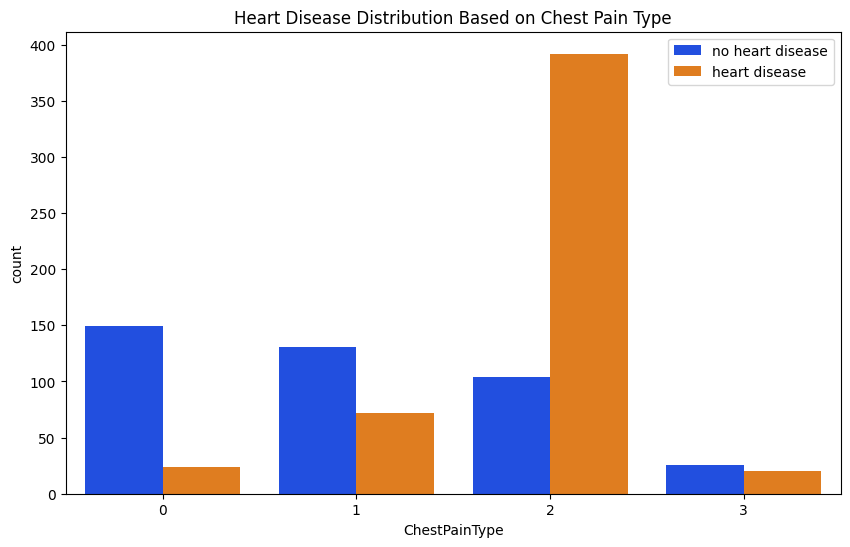

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(x="ChestPainType", data=df, palette='bright',hue='HeartDisease')
plt.legend(['no heart disease','heart disease'])
plt.title('Heart Disease Distribution Based on Chest Pain Type')

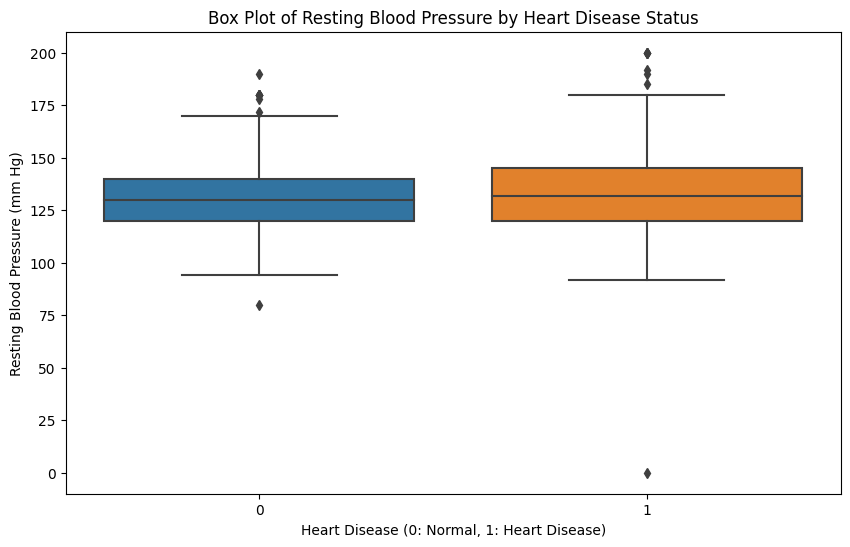

In [19]:
# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='HeartDisease', y='RestingBP', data=df)
plt.title('Box Plot of Resting Blood Pressure by Heart Disease Status')
plt.xlabel('Heart Disease (0: Normal, 1: Heart Disease)')
plt.ylabel('Resting Blood Pressure (mm Hg)')
plt.show()

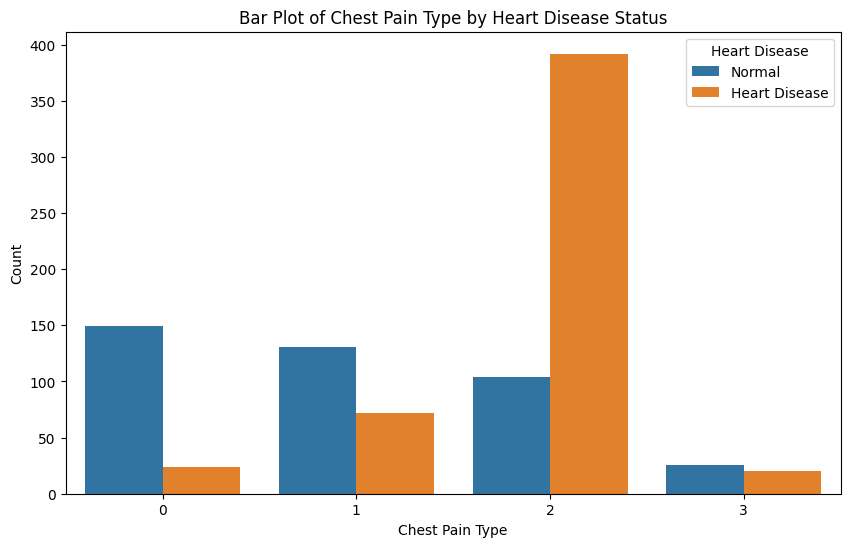

In [20]:
# Bar Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='ChestPainType', hue='HeartDisease', data=df)
plt.title('Bar Plot of Chest Pain Type by Heart Disease Status')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['Normal', 'Heart Disease'])
plt.show()

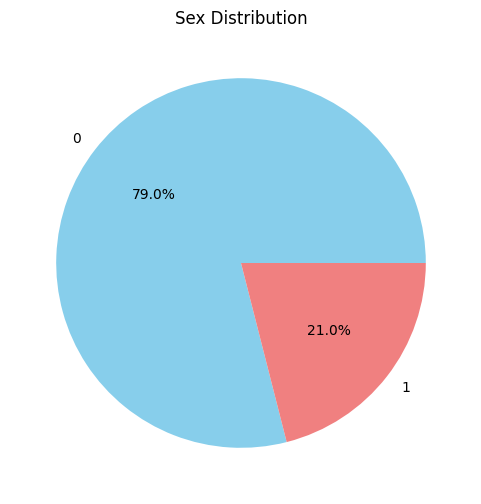

In [21]:
plt.figure(figsize=(6, 6))
df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Sex Distribution')
plt.ylabel('')
plt.show()

**79% of distribution of data is of male and 21.0% is of females**.

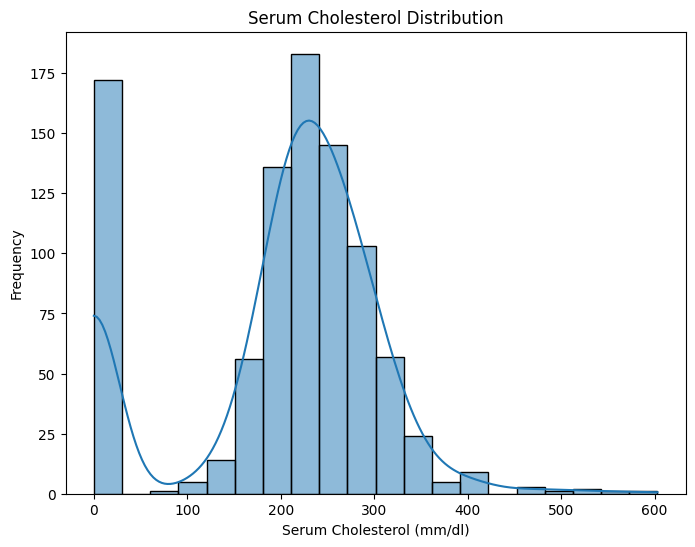

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Cholesterol', bins=20, kde=True)
plt.title('Serum Cholesterol Distribution')
plt.xlabel('Serum Cholesterol (mm/dl)')
plt.ylabel('Frequency')
plt.show()

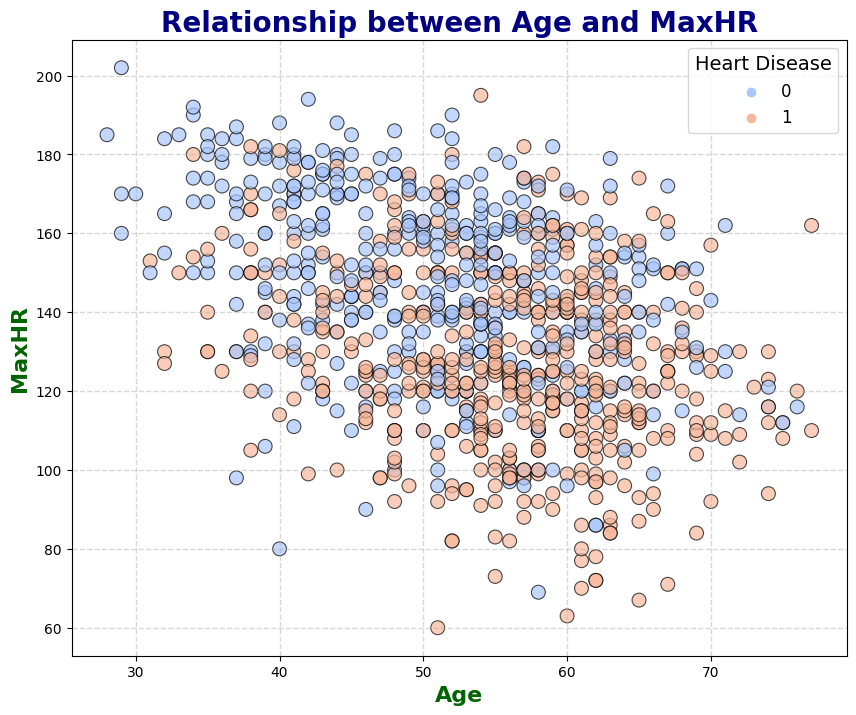

In [23]:
# Relationship between Age and MaxHR
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Age', y='MaxHR', data=df, hue='HeartDisease', palette='coolwarm', alpha=0.7, edgecolor='black', s=100)
plt.title('Relationship between Age and MaxHR', fontsize=20, fontweight='bold', color='navy')
plt.xlabel('Age', fontsize=16, fontweight='bold', color='darkgreen')
plt.ylabel('MaxHR', fontsize=16, fontweight='bold', color='darkgreen')
plt.legend(title='Heart Disease', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.show()

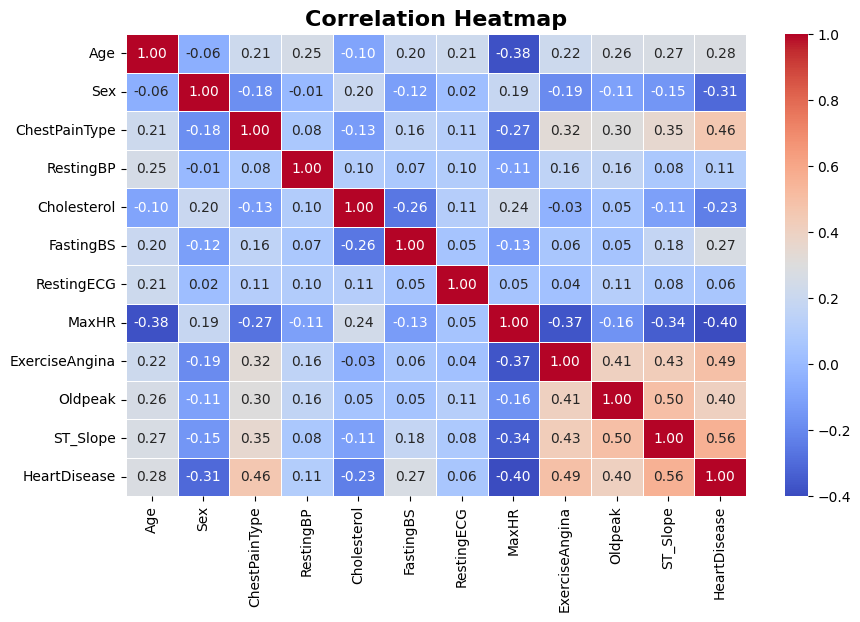

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

In [25]:
from tabulate import tabulate
def calculate_statistical_moments(data):
    """
    Calculate statistical moments (mean, median, standard deviation, skewness, kurtosis) for each feature in the dataset.

    Parameters:
    - data_copy (DataFrame): Input data_copy containing features.

    Returns:
    - DataFrame: DataFrame containing statistical moments for each feature.
    """
    moments = {
        'Mean': data.mean(),
        'Median': data.median(),
        'Standard Deviation': data.std(),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    }
    return pd.DataFrame(moments)

def display_statistical_moments(data):
    """
    Display statistical moments (mean, median, standard deviation, skewness, kurtosis) for each feature in the dataset.

    Parameters:
    - data_copy (DataFrame): Input data_copy containing features.
    """
    moments_df = calculate_statistical_moments(data)
    print("\nStatistical Moments:\n")
    print(tabulate(moments_df, headers='keys', tablefmt='grid', showindex=True, numalign="center", stralign='center'))

display_statistical_moments(df)


Statistical Moments:

+----------------+----------+----------+----------------------+------------+------------+
|                |   Mean   |  Median  |  Standard Deviation  |  Skewness  |  Kurtosis  |
+================+==========+==========+======================+============+============+
|      Age       | 53.5109  |    54    |       9.43262        | -0.195933  |  -0.38614  |
+----------------+----------+----------+----------------------+------------+------------+
|      Sex       | 0.21024  |    0     |       0.407701       |  1.42454   | 0.0293722  |
+----------------+----------+----------+----------------------+------------+------------+
| ChestPainType  | 1.45207  |    2     |       0.851832       | -0.523761  | -0.744938  |
+----------------+----------+----------+----------------------+------------+------------+
|   RestingBP    | 132.397  |   130    |       18.5142        |  0.179839  |  3.27125   |
+----------------+----------+----------+----------------------+------------+-

# Model Training

In [29]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X.shape, y.shape

((918, 11), (918,))

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

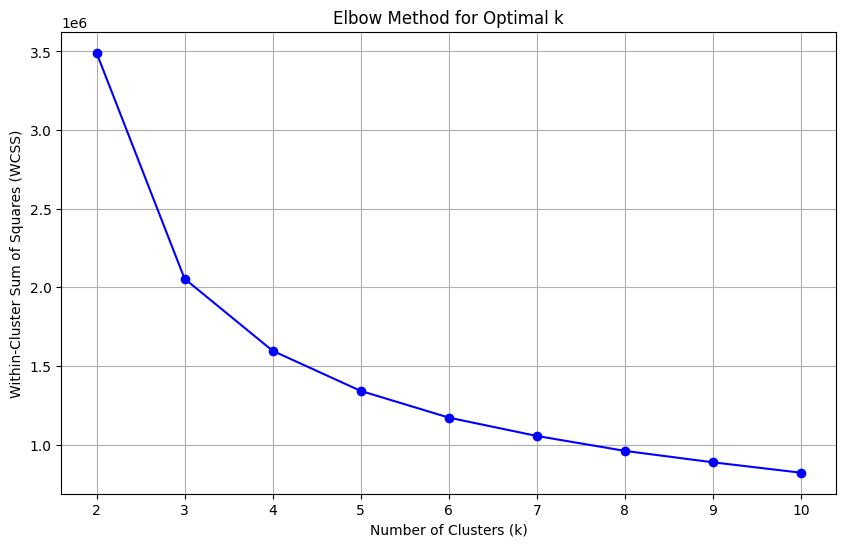

In [49]:
# Initialize lists to store inertia values
inertia_values = []

# Test different values of k (number of clusters)
k_values = range(2, 11)  # Test k from 2 to 10

for k in k_values:
    # Create KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Append the inertia value to the list
    inertia_values.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

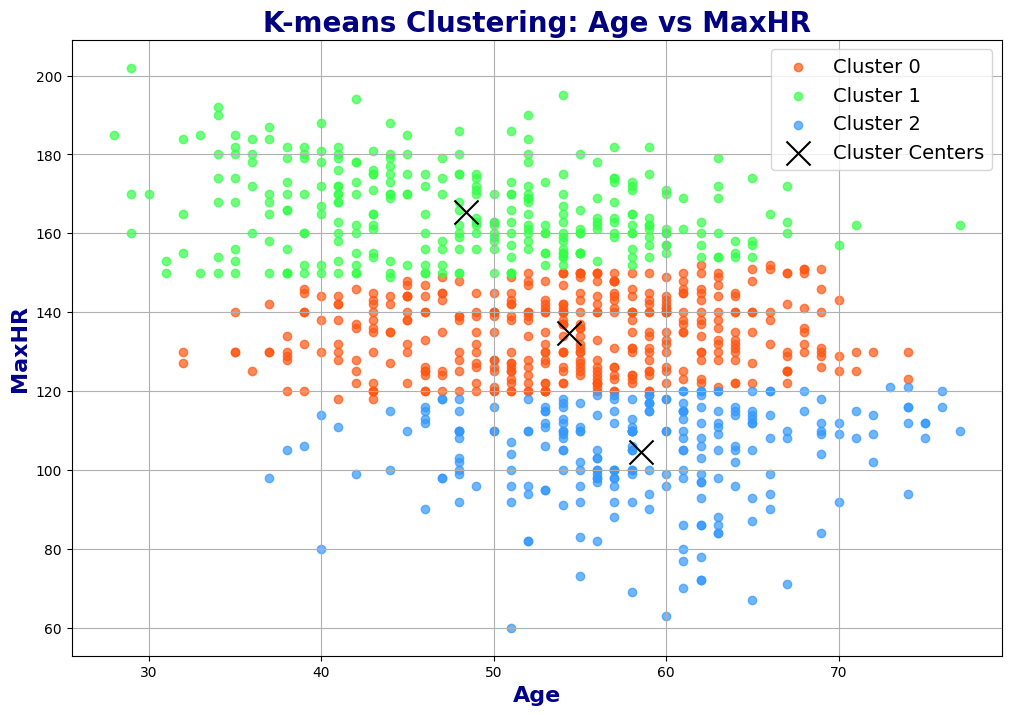

In [54]:
def plot_clusters(df):
    """
    Perform K-means clustering on the top 2 features and plot the clusters.

    Parameters:
    - df (DataFrame): Input DataFrame containing features.
    """
    # Choose the top 2 features for clustering
    features = ['Age', 'MaxHR']
    
    # Perform K-means clustering
    km = KMeans(n_clusters=3, random_state=42)  # Specify the number of clusters
    df['cluster'] = km.fit_predict(df[features])  # Fit K-means and assign cluster labels

    # Set custom colors for clusters
    colors = ['#FF5713', '#33FF47', '#3398FF']  # You can choose your own colors here

    # Plot clusters with cluster centers
    plt.figure(figsize=(12, 8))

    # Plot each cluster using a different color
    for cluster_label, color in zip(sorted(df['cluster'].unique()), colors):
        cluster_data = df[df['cluster'] == cluster_label]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster_label}', alpha=0.7, color=color)

    # Plot cluster centers
    cluster_centers = km.cluster_centers_
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=300, c='black', label='Cluster Centers')

    # Set plot title and labels
    plt.title(f'K-means Clustering: {features[0]} vs {features[1]}', fontsize=20, fontweight='bold', color='navy')
    plt.xlabel(features[0], fontsize=16, fontweight='bold', color='darkblue')
    plt.ylabel(features[1], fontsize=16, fontweight='bold', color='darkblue')

    # Add legend
    plt.legend(fontsize=14)
    plt.grid(True)

    plt.show()

plot_clusters(df)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        77
           1       0.91      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184



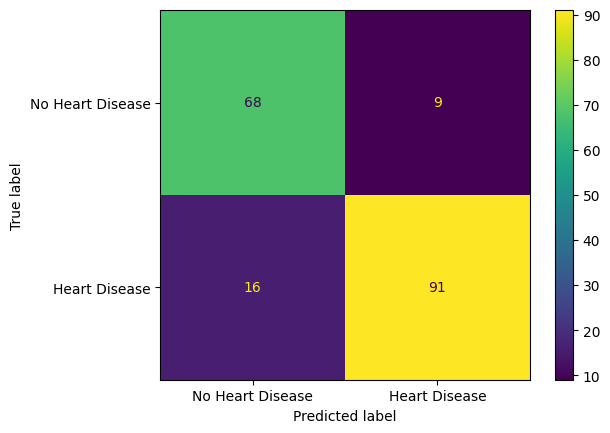

In [30]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=['No Heart Disease','Heart Disease']).plot()

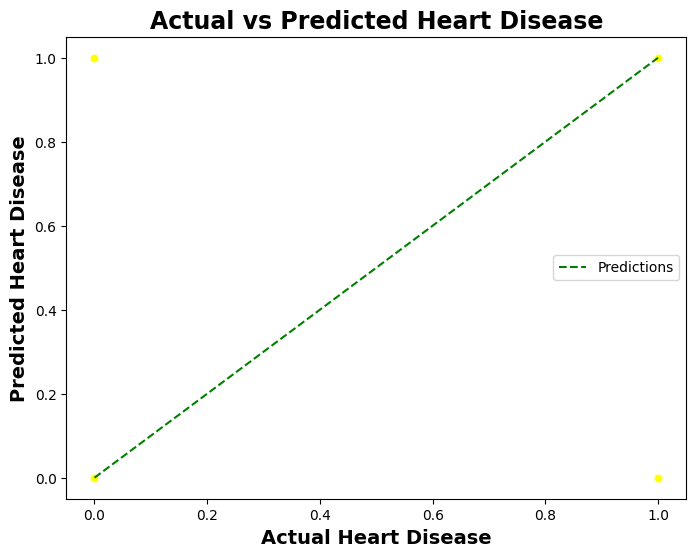

In [56]:
# Plot the predicted vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='yellow', alpha=0.7)
plt.plot(y_pred, y_pred, color='green', linestyle='--', label='Predictions')  # Plot the diagonal line for perfect predictions
plt.title('Actual vs Predicted Heart Disease', fontsize=17, fontweight='bold')
plt.xlabel('Actual Heart Disease', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Heart Disease', fontsize=14, fontweight='bold')
plt.legend()
plt.show()